# First import the necessery libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, BatchNormalization, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading the Dataset

In [2]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
print(train_df.shape)
train_df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(test_df.shape)
test_df.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print("*" * 10, 'Labels', "*" * 10)
display(train_df['label'].value_counts())
print("-" * 30)
display(train_df['label'].describe())
print("=" * 40)

********** Labels **********


label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

------------------------------


count    42000.000000
mean         4.456643
std          2.887730
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: label, dtype: float64

# Split the data into Features Matrix(X) & Target Vector(y)

In [6]:
X_train = train_df.drop(labels = ["label"],axis = 1) 
y_train = train_df["label"]

### Plot the Labels 

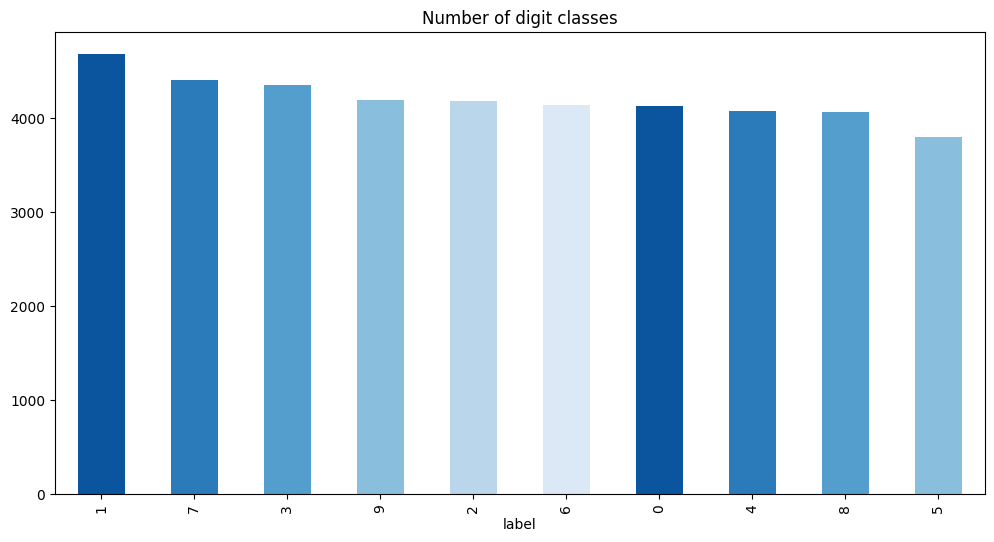

In [7]:
digits_counts = y_train.value_counts()
digits_counts.plot(kind = 'bar', color = sns.color_palette("Blues_r"), title = "Number of digit classes", figsize = (12,6));

    Seems like all the digits in the same range, So the label is Balanced

# Reshape the data to (28*28) 

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test_df.values.reshape(-1,28,28,1)

    Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only  one channel. 

# Plot some images

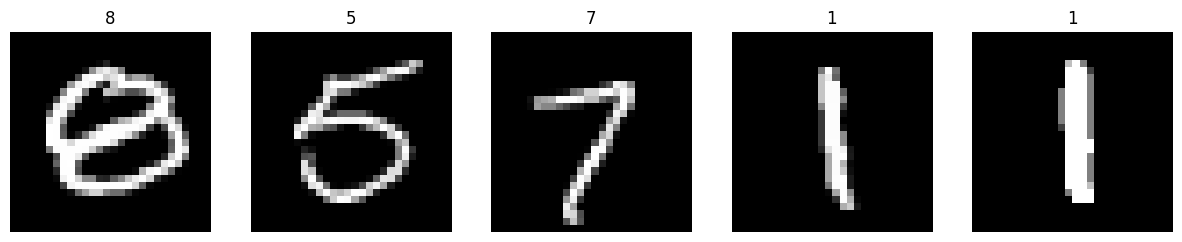

In [9]:
def plot_images(data, num_of_images):
    plt.figure(figsize=(15,10))
    for i in range(num_of_images):
        index = random.randint(0,len(train_df)) # Get a random row index to display the img of whis row
            
        plt.subplot(1,num_of_images,i+1)
        plt.imshow(data[index],cmap='gray') # Displaying the image in grayscale mode
        plt.title(y_train[index]) # Since the test data don't contain the label,so I used the y_train
        plt.axis('off')
    
    plt.show()
    
plot_images(X_train,5)

# Convert the training data into train & validation

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

print("Train:")
print(X_train.shape)
print(y_train.shape)
print("\nTest:")
print(X_val.shape)
print(y_val.shape)

Train:
(33600, 28, 28, 1)
(33600,)

Test:
(8400, 28, 28, 1)
(8400,)


# Rescale the images & Image Augmentation

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=15,
                                    zoom_range = 0.15,  
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16, shuffle=True)

    The image augmentation help avoid overfitting in small datasets

# Making the Model

In [12]:
model = Sequential()

model.add(InputLayer(input_shape=(28,28,1)))

model.add(Conv2D(16, (3*3), activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(32, (3*3), activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 16)        1312      
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 32)          41504     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 256)               8

In [14]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1.5e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_generator, epochs=15, validation_data=val_generator)

Epoch 1/15
2100/2100 [==============================] - 28s 9ms/step - loss: 0.8111 - accuracy: 0.7471 - val_loss: 0.1978 - val_accuracy: 0.9473
Epoch 2/15
2100/2100 [==============================] - 19s 9ms/step - loss: 0.3196 - accuracy: 0.9064 - val_loss: 0.1291 - val_accuracy: 0.9632
Epoch 3/15
2100/2100 [==============================] - 19s 9ms/step - loss: 0.2340 - accuracy: 0.9310 - val_loss: 0.1089 - val_accuracy: 0.9681
Epoch 4/15
2100/2100 [==============================] - 19s 9ms/step - loss: 0.2026 - accuracy: 0.9405 - val_loss: 0.0914 - val_accuracy: 0.9736
Epoch 5/15
2100/2100 [==============================] - 19s 9ms/step - loss: 0.1787 - accuracy: 0.9471 - val_loss: 0.0746 - val_accuracy: 0.9768
Epoch 6/15
2100/2100 [==============================] - 19s 9ms/step - loss: 0.1640 - accuracy: 0.9493 - val_loss: 0.0709 - val_accuracy: 0.9799
Epoch 7/15
2100/2100 [==============================] - 19s 9ms/step - loss: 0.1510 - accuracy: 0.9555 - val_loss: 0.0703 - val_ac

# Plot the accuracy

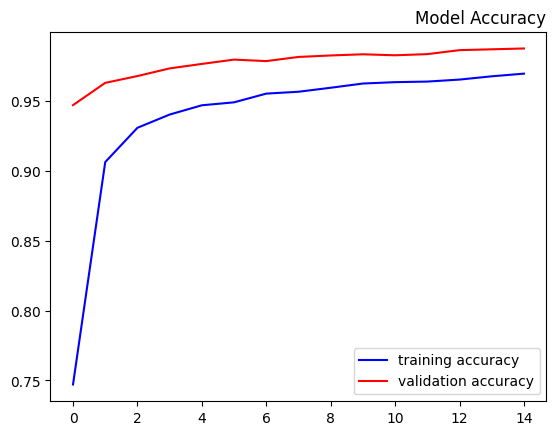

In [16]:
tarin_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(tarin_acc, c = 'b', label = 'training accuracy')
plt.plot(val_acc, c = 'r', label = 'validation accuracy')
plt.title('Model Accuracy', loc ='right')
plt.legend()
plt.show()

# Plot the Loss

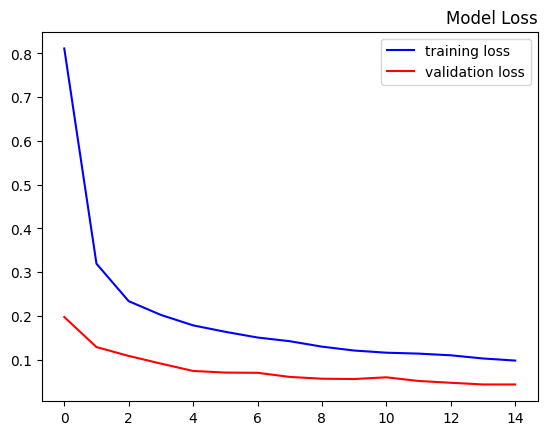

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, c = 'b', label = 'training loss')
plt.plot(val_loss, c = 'r', label = 'validation loss')
plt.title('Model Loss', loc ='right')
plt.legend()
plt.show()

### Submission 

In [18]:
results = model.predict(test)

results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv('Submission.csv',index=False)

875/875 [==============================] - 2s 2ms/step
